In [28]:

import datetime as dt
import json
import logging
import math
import scipy

import astropy.time as astt
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import requests
from astropy.table import Table
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats

logging.getLogger('matplotlib').setLevel(logging.FATAL)

plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use('ggplot')

log = logging.getLogger(__name__)
logging.basicConfig(level=getattr(logging,'INFO'), format='%(asctime)s.%(msecs).03d %(levelname)7s: %(module)20s: %(message)s')

In [22]:
def get_1meter_exposuretimes(after=dt.datetime.now() - dt.timedelta(days=365), before=dt.datetime.now()):
    """Get focus-relevant fits header keywords for end of focus exposures,
       as a proxy for the ideally focused telescope state """

    sourcecolumn = ['EXPTIME', 'DATE-OBS',]
    query = f'OBSTYPE:EXPOSE AND TELESCOP:1m* AND INSTRUME:fa* AND RLEVEL:91'\
            f' AND DATE-OBS:[{after.strftime("%Y-%m-%dT%H:%M:%S")} TO {before.strftime("%Y-%m-%dT%H:%M:%S")}]'

    log.info(f"Query: {query}")

    headers = {'Content-type': 'application/json'}
    page_size = 5000
    all_records = []
    from_ = 0

    while True:
        body = {
            "size": page_size,
            "from": from_,
            "_source": sourcecolumn,
            "query": {
                "query_string": {
                   "query": query
                }
            }
        }
        
        response = requests.get('https://opensearch.lco.global:443/fitsheaders/_search',
                            data=json.dumps(body), headers=headers).json()
        hits = response.get('hits', {}).get('hits', [])
        if not hits:
            break

        all_records.extend([r['_source'] for r in hits])
        log.info(f"Fetched {len(hits)} records (total so far: {len(all_records)})")
        if len(hits) < page_size:
            break
        from_ += page_size
    # make a nice table out of that convoluted mess
    t = [[item[col] for col in sourcecolumn] for item in all_records]
    t = np.asarray(t)
    
    log.info(f"Number of raw records {len(t)}")
    if len(t) == 0:
        log.warning("Warning: empty return")
        return None

    try:
        dtypes = [float for ii in range(len(sourcecolumn))]
        dtypes[sourcecolumn.index('DATE-OBS')] = str
          
        t = Table(t, names=sourcecolumn,
                  dtype=dtypes)
        t['DATE-OBS'] = astt.Time(t['DATE-OBS'], scale='utc', format=None).to_datetime()
     
    except:
        log.exception("Error parsing opensearch return")
        return None

    fullsize = len(t)
      
    log.info(f"Number of  records: {fullsize}")
    return t


data = get_1meter_exposuretimes()

2025-09-09 15:33:59,379.379    INFO:           2342322082: Query: OBSTYPE:EXPOSE AND TELESCOP:1m* AND INSTRUME:fa* AND RLEVEL:91 AND DATE-OBS:[2024-09-09T15:33:59 TO 2025-09-09T15:33:59]
2025-09-09 15:34:05,780.780    INFO:           2342322082: Fetched 5000 records (total so far: 5000)
2025-09-09 15:34:10,050.050    INFO:           2342322082: Fetched 5000 records (total so far: 10000)
2025-09-09 15:34:11,299.299    INFO:           2342322082: Number of raw records 10000
2025-09-09 15:34:11,319.319    INFO:           2342322082: Number of  records: 10000


1m Exposure Time Distribution (last year): median=30.0s, mean=66.6s, std=81.0s, mode=30.0s


/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_33068/1117198358.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = scipy.stats.mode(data['EXPTIME'])[0][0]


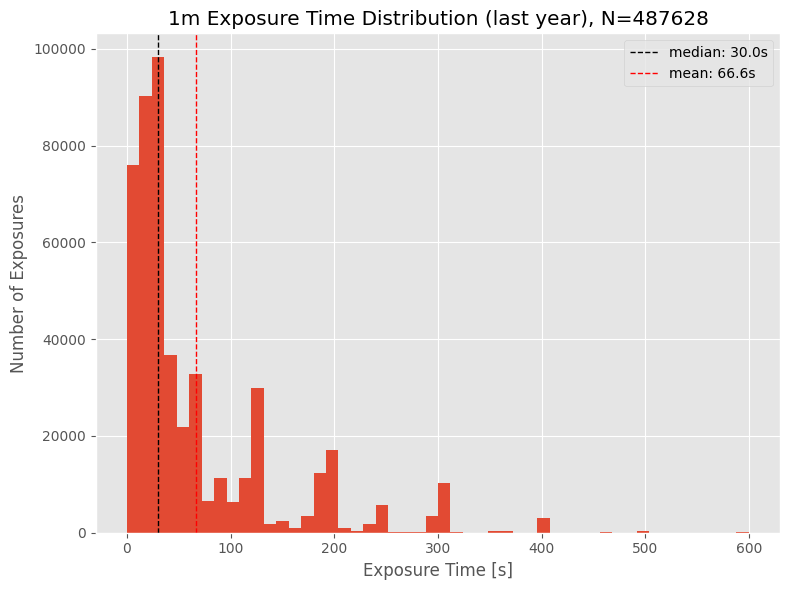

In [32]:
plt.hist(data['EXPTIME'], bins=50, range=(0,600))
median = np.median(data['EXPTIME'])
mean = np.mean(data['EXPTIME'])
std = np.std(data['EXPTIME'])
mode = scipy.stats.mode(data['EXPTIME'])[0][0]
print (f"1m Exposure Time Distribution (last year): median={median:.1f}s, mean={mean:.1f}s, std={std:.1f}s, mode={mode:.1f}s")

plt.xlabel('Exposure Time [s]')
plt.ylabel('Number of Exposures')
plt.title(f'1m Exposure Time Distribution (last year), N={len(data["EXPTIME"])}')
plt.axvline(median, color='k', linestyle='dashed', linewidth=1, label=f'median: {median:.1f}s')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'mean: {mean:.1f}s')
plt.legend()
plt.tight_layout()
plt.savefig('1m_exposure_time_distribution.png')

plt.show()

In [25]:
def get_1meter_exposuretimes_scroll(after=dt.datetime.now() - dt.timedelta(days=365), before=dt.datetime.now()):
        
    sourcecolumn = ['EXPTIME', 'DATE-OBS']
    query = (
        f'OBSTYPE:EXPOSE AND TELESCOP:1m* AND INSTRUME:fa* AND RLEVEL:91'
        f' AND DATE-OBS:[{after.strftime("%Y-%m-%dT%H:%M:%S")} TO {before.strftime("%Y-%m-%dT%H:%M:%S")}]'
    )
    log.info(f"Query: {query}")

    headers = {'Content-type': 'application/json'}
    url = 'https://opensearch.lco.global:443/fitsheaders/_search?scroll=2m'
    page_size = 10000  # smaller page size for scroll API
    all_records = []

    # Initial search with scroll
    body = {
        "size": page_size,
        "_source": sourcecolumn,
        "query": {
            "query_string": {
                "query": query
            }
        }
    }
    response = requests.get(url, data=json.dumps(body), headers=headers).json()
    scroll_id = response.get('_scroll_id')
    hits = response.get('hits', {}).get('hits', [])
    all_records.extend([r['_source'] for r in hits])
    log.info(f"Fetched {len(hits)} records (total so far: {len(all_records)})")

    # Continue scrolling
    while True:
        if not scroll_id or not hits:
            break
        scroll_body = {
            "scroll": "2m",
            "scroll_id": scroll_id
        }
        scroll_url = 'https://opensearch.lco.global:443/_search/scroll'
        response = requests.post(scroll_url, data=json.dumps(scroll_body), headers=headers).json()
        scroll_id = response.get('_scroll_id')
        hits = response.get('hits', {}).get('hits', [])
        if not hits:
            break
        all_records.extend([r['_source'] for r in hits])
        log.info(f"Fetched {len(hits)} records (total so far: {len(all_records)})")

    log.info(f"Number of raw records {len(all_records)}")
    if len(all_records) == 0:
        log.warning("Warning: empty return")
        return None

    t = [[item.get(col, np.nan) for col in sourcecolumn] for item in all_records]
    t = np.asarray(t)

    try:
        dtypes = [float for ii in range(len(sourcecolumn))]
        dtypes[sourcecolumn.index('DATE-OBS')] = str
        t = Table(t, names=sourcecolumn, dtype=dtypes)
        t['DATE-OBS'] = astt.Time(t['DATE-OBS'], scale='utc', format=None).to_datetime()
    except Exception:
        log.exception("Error parsing opensearch return")
        return None

    fullsize = len(t)
    t.sort('DATE-OBS')
    log.info(f"Number of records: {fullsize}")
    return t

data = get_1meter_exposuretimes_scroll()

2025-09-09 15:42:02,136.136    INFO:            961301041: Query: OBSTYPE:EXPOSE AND TELESCOP:1m* AND INSTRUME:fa* AND RLEVEL:91 AND DATE-OBS:[2024-09-09T15:42:02 TO 2025-09-09T15:42:02]
2025-09-09 15:42:04,839.839    INFO:            961301041: Fetched 1000 records (total so far: 1000)
2025-09-09 15:42:06,131.131    INFO:            961301041: Fetched 1000 records (total so far: 2000)
2025-09-09 15:42:07,614.614    INFO:            961301041: Fetched 1000 records (total so far: 3000)
2025-09-09 15:42:08,832.832    INFO:            961301041: Fetched 1000 records (total so far: 4000)
2025-09-09 15:42:09,872.872    INFO:            961301041: Fetched 1000 records (total so far: 5000)
2025-09-09 15:42:11,197.197    INFO:            961301041: Fetched 1000 records (total so far: 6000)
2025-09-09 15:42:12,607.607    INFO:            961301041: Fetched 1000 records (total so far: 7000)
2025-09-09 15:42:13,916.916    INFO:            961301041: Fetched 1000 records (total so far: 8000)
2025-